# **Loads CAPTCHA images**

In [ ]:
import os
from google.colab import drive

# Mount to google drive
drive.mount('/content/drive', force_remount=True)

# Folder path for captcha dataset
folder_path = '/content/drive/MyDrive/Main'
#folder_path = '/content/drive/MyDrive/CAPTCHA Database'

jpg_files = []

try:
    # Go through all directories and files in folder_path
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.jpg'):  # Find all .jpg files in folder
                jpg_files.append(os.path.join(root, file))

    # Now jpg_files contains all the paths to the .jpg files
    # Prints out how many .jpg files have been loaded
    print(f"Found {len(jpg_files)} .jpg files.")

except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
Found 10029 .jpg files.


# **Creates RESNET Model**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_resnet_model(input_shape, num_classes, num_chars):
    # Load a ResNet model, pre-initialized with weights trained on ImageNet
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')

    # Freeze the layers of the base_model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model on top
    x = base_model.output
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    # Adjust the final Dense layer to your number of classes multiplied by the CAPTCHA length
    x = layers.Dense(num_chars * num_classes, activation='softmax')(x)
    # Reshape to the format expected by the rest of your code
    x = layers.Reshape((num_chars, num_classes))(x)

    model = models.Model(inputs=base_model.input, outputs=x)

    return model

# Adjust these parameters to fit your dataset
input_shape = (40, 150, 3)  # Adjust based on your CAPTCHA image size
num_classes = 62  # Assuming you're using 0-9, a-z, A-Z
num_chars = 5  # Adjust based on your CAPTCHA length

# Initialize the model
model = build_resnet_model(input_shape, num_classes, num_chars)

# Compile the model
optimizer = Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 150, 3)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 46, 156, 3)           0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 20, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 20, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                         

# **Preprocesses Data**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import os

# Preprocessing images and labels
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)

    # Check if the image has been loaded correctly
    if image is None:
        raise ValueError(f"Unable to load image at {image_path}. Please check the file path and access permissions.")

    # If image is loaded, convert color scheme and normalize pixel values
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to 0-1 range
    return image

# Character Index Mapping
import string

# Create a mapping of characters to integers
characters = string.digits + string.ascii_lowercase + string.ascii_uppercase
char_to_index = {char: index for index, char in enumerate(characters)}
index_to_char = {index: char for char, index in char_to_index.items()}



def encode_label(label):
    # Initialize a matrix of zeros with shape (len(label), 62)
    encoded = np.zeros((len(label), 62))

    for i, char in enumerate(label):
        index = char_to_index[char]  # Get the index for this character
        encoded[i, index] = 1  # Set the appropriate element to 1

    return encoded


# Load and preprocess the dataset
images = []
labels = []
count = 0
total_files = len(os.listdir(folder_path))  # Get the total number of files to process

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        try:
            label = filename.split('.')[0]  # This is a simplification
            image_path = os.path.join(folder_path, filename)
            image = preprocess_image(image_path)

            images.append(image)
            labels.append(encode_label(label))
            count += 1

            # Print progress every 100 images
            if count % 100 == 0:
                print(f"Processed {count}/{total_files} images.")
        except Exception as e:
            print(f"Failed to process image {filename}: {e}")

# Now 'images' and 'labels' are populated with preprocessed data
print(f"Finished processing all images. Total processed images: {count}")

images = np.array(images)
labels = np.array(labels)

Processed 100/10030 images.
Processed 200/10030 images.
Processed 300/10030 images.
Processed 400/10030 images.
Processed 500/10030 images.
Processed 600/10030 images.
Processed 700/10030 images.
Processed 800/10030 images.
Processed 900/10030 images.
Processed 1000/10030 images.
Processed 1100/10030 images.
Processed 1200/10030 images.
Processed 1300/10030 images.
Processed 1400/10030 images.
Processed 1500/10030 images.
Processed 1600/10030 images.
Processed 1700/10030 images.
Processed 1800/10030 images.
Processed 1900/10030 images.
Processed 2000/10030 images.
Processed 2100/10030 images.
Processed 2200/10030 images.
Processed 2300/10030 images.
Processed 2400/10030 images.
Processed 2500/10030 images.
Processed 2600/10030 images.
Processed 2700/10030 images.
Processed 2800/10030 images.
Processed 2900/10030 images.
Processed 3000/10030 images.
Processed 3100/10030 images.
Processed 3200/10030 images.
Processed 3300/10030 images.
Processed 3400/10030 images.
Processed 3500/10030 im

KeyboardInterrupt: 

# **Split data**

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# **Train**

In [ ]:
6# Train your model
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
57/57 [==============================] - 62s 1s/step - loss: 3.8850 - accuracy: 0.1021 - val_loss: 3.5260 - val_accuracy: 0.1240
Epoch 2/100
57/57 [==============================] - 62s 1s/step - loss: 3.5803 - accuracy: 0.1167 - val_loss: 3.4409 - val_accuracy: 0.1267
Epoch 3/100
57/57 [==============================] - 63s 1s/step - loss: 3.5132 - accuracy: 0.1221 - val_loss: 3.4169 - val_accuracy: 0.1287
Epoch 4/100
57/57 [==============================] - 62s 1s/step - loss: 3.4851 - accuracy: 0.1237 - val_loss: 3.4081 - val_accuracy: 0.1363
Epoch 5/100
57/57 [==============================] - 64s 1s/step - loss: 3.4643 - accuracy: 0.1281 - val_loss: 3.4025 - val_accuracy: 0.1323
Epoch 6/100
57/57 [==============================] - 65s 1s/step - loss: 3.4535 - accuracy: 0.1272 - val_loss: 3.3987 - val_accuracy: 0.1367
Epoch 7/100
57/57 [==============================] - 56s 993ms/step - loss: 3.4398 - accuracy: 0.1329 - val_loss: 3.3955 - val_accuracy: 0.1377
Epoch 8/10

# **Test**

In [ ]:
# After training, evaluate model on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

7/7 - 5s - loss: 3.2032 - accuracy: 0.2190 - 5s/epoch - 650ms/step
Test accuracy: 0.21899999678134918, Test loss: 3.20322847366333


# **Pick random CAPTCHA image from testing set and make prections**

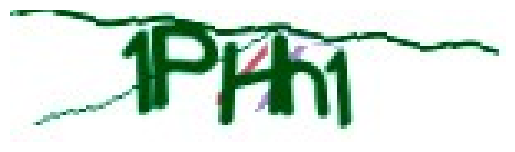

1/1 [==============================] - 0s 65ms/step
Predicted characters: 1LULW
True characters: 1PHh1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a random image from the training set
random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
random_label = y_test[random_index]

# Display the chosen image
plt.imshow(random_image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Reshape the image to match the model's input format
random_image = np.expand_dims(random_image, axis=0)

# Predict the characters in the image
prediction = model.predict(random_image)
m
# Decode the prediction
predicted_label = [index_to_char[np.argmax(char)] for char in prediction[0]]

# Convert the one-hot encoded true label to characters
true_label = [index_to_char[np.argmax(char)] for char in random_label]

print(f"Predicted characters: {''.join(predicted_label)}")
print(f"True characters: {''.join(true_label)}")